# House Prices and Nutrition

## I) Module imports

In [1]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from utils import calculate_nutripoints
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pprint
pp = pprint.PrettyPrinter(depth=4)

sns.color_palette("colorblind")
np.random.seed(42)

sns.set_theme('notebook')

In [2]:
%load_ext autoreload
%autoreload 2

## II) Data imports

In [3]:
NUTRITION_COLS = ["area_id", "energy_tot", "energy_fat", "energy_saturate", "energy_sugar", "energy_protein",
                  "energy_carb", "energy_fibre", "energy_alcohol", "h_nutrients_calories"]

year_grocery = pd.read_csv("data/year_lsoa_grocery.csv")
print(year_grocery.shape)
display(year_grocery.head())

(4833, 202)


,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,man_day,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km
0,E01000001,308.119047,35.0,150.0,250.0,400.0,900.0,266.851723,2.359404,97.218600,...,16033,1296.0,685.0,611.0,179.0,766.0,351.0,48.293981,0.13,9985.0
1,E01000002,313.517874,40.0,150.0,250.0,400.0,900.0,256.227843,2.833812,88.262314,...,7829,1156.0,616.0,540.0,197.0,656.0,303.0,47.398789,0.23,5061.0
2,E01000003,315.084751,35.0,150.0,250.0,400.0,1000.0,292.462262,2.763918,102.240558,...,15065,1350.0,713.0,637.0,152.0,850.0,348.0,48.360741,0.06,22843.0
3,E01000005,356.033437,38.0,150.0,280.0,450.0,1000.0,436.559315,2.554110,113.968805,...,25128,1121.0,604.0,517.0,294.0,675.0,152.0,35.611954,0.19,5912.0
4,E01000006,451.262063,36.0,180.0,325.0,500.0,1500.0,666.655869,7.744708,133.322097,...,5860,2040.0,1040.0,1000.0,563.0,1317.0,160.0,32.080392,0.15,13915.0


In [4]:
min_grocery = year_grocery[['energy_tot', 'saturate', 'salt',
                            'sugar', 'f_fruit_veg', 'fibre', 'protein']].min(axis=0)

max_grocery = year_grocery[['energy_tot', 'saturate', 'salt',
                            'sugar', 'f_fruit_veg', 'fibre', 'protein']].max(axis=0)

year_grocery["nutripoints"] = year_grocery.apply(
    lambda row: calculate_nutripoints(row, min_grocery, max_grocery), axis=1)

In [5]:
COLS = ["Code", "Year ending Dec 2014"]

housing_prices = pd.read_excel(
    "data/land-registry-house-prices-LSOA.xls", sheet_name="Mean")[COLS]
housing_prices.rename(
    columns={"Year ending Dec 2014": "mean house price"}, inplace=True)
housing_prices.dropna(inplace=True)

print(housing_prices.shape)
display(housing_prices.head())

(4835, 2)


,Code,mean house price
1,E01000001,853613
2,E01000002,1.02526e+06
3,E01000003,598329
4,E01000005,417325
5,E01032739,906953


### A) Merge datasets

In [6]:
grocery_housing = pd.merge(
    year_grocery, housing_prices, left_on="area_id", right_on="Code")
grocery_housing.drop("Code", axis=1, inplace=True)

In [7]:
grocery_housing['mean house price'] = pd.to_numeric(
    grocery_housing['mean house price'], errors='coerce')
display(grocery_housing)

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km,nutripoints,mean house price
0,E01000001,308.119047,35.0,150.0,250.0,400.0,900.0,266.851723,2.359404,97.218600,...,685.0,611.0,179.0,766.0,351.0,48.293981,0.13,9985.0,1.5,8.536125e+05
1,E01000002,313.517874,40.0,150.0,250.0,400.0,900.0,256.227843,2.833812,88.262314,...,616.0,540.0,197.0,656.0,303.0,47.398789,0.23,5061.0,0.5,1.025264e+06
2,E01000003,315.084751,35.0,150.0,250.0,400.0,1000.0,292.462262,2.763918,102.240558,...,713.0,637.0,152.0,850.0,348.0,48.360741,0.06,22843.0,1.5,5.983287e+05
3,E01000005,356.033437,38.0,150.0,280.0,450.0,1000.0,436.559315,2.554110,113.968805,...,604.0,517.0,294.0,675.0,152.0,35.611954,0.19,5912.0,1.5,4.173250e+05
4,E01000006,451.262063,36.0,180.0,325.0,500.0,1500.0,666.655869,7.744708,133.322097,...,1040.0,1000.0,563.0,1317.0,160.0,32.080392,0.15,13915.0,4.5,2.494412e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4828,E01033742,387.401492,37.5,170.0,300.0,500.0,1000.0,402.790826,2.671220,100.481483,...,902.0,799.0,335.0,1241.0,125.0,33.250441,0.13,13532.0,2.0,2.269445e+05
4829,E01033743,420.188421,33.0,170.0,340.0,500.0,1500.0,495.895799,4.655028,106.949648,...,1225.0,1201.0,844.0,1494.0,88.0,29.259275,1.00,2423.0,2.5,2.020000e+05
4830,E01033744,402.531751,35.0,170.0,300.0,500.0,1200.0,499.572412,3.129316,113.476785,...,964.0,936.0,549.0,1220.0,131.0,31.960526,0.15,12952.0,3.0,2.280455e+05
4831,E01033745,435.686457,40.0,182.0,350.0,500.0,1500.0,536.871624,6.140228,120.670999,...,961.0,993.0,680.0,1202.0,72.0,30.143296,0.56,3465.0,3.5,2.081475e+05


## Exploratory Data Analysis

377024.72222


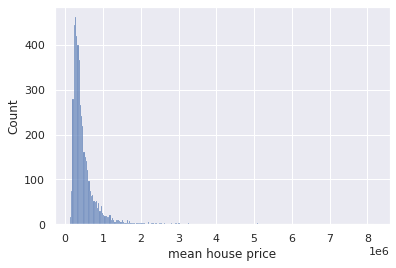

In [8]:
ax = sns.histplot(data=grocery_housing, x="mean house price")

print(grocery_housing["mean house price"].median())

504643.6355953608 377024.72222 1.3384895097168008


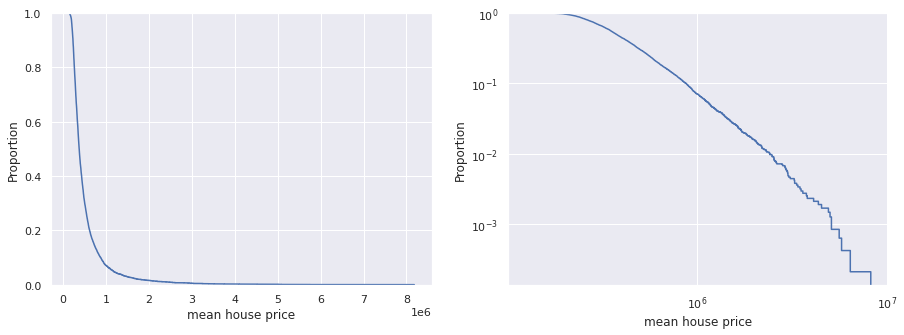

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.ecdfplot(data=grocery_housing, x="mean house price",
             complementary=True, ax=ax[0])
sns.ecdfplot(data=grocery_housing, x="mean house price",
             complementary=True, ax=ax[1])
ax[1].set(xscale="log", yscale="log")


price_mean = grocery_housing["mean house price"].mean()
price_median = grocery_housing["mean house price"].median()

print(price_mean, price_median, price_mean / price_median)

The data is skewed to the right, with a long tail of high scores pulling the mean up more than the median. According to the graphs, the data clearly does not follow a normal distribution.

Text(0, 0.5, 'spearman correlation')

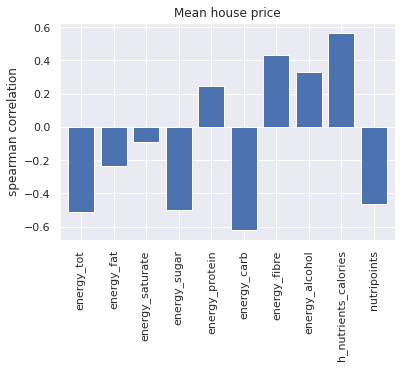

In [10]:
COLS = ["energy_tot", "energy_fat", "energy_saturate", "energy_sugar", "energy_protein",
        "energy_carb", "energy_fibre", "energy_alcohol", "h_nutrients_calories", "nutripoints"]

correlation = grocery_housing.corr(method="spearman").loc[COLS]

correlation['mean house price'].plot.bar(
    x=None, y=None, width=0.8, legend=None)

plt.title("Mean house price")
plt.ylabel("spearman correlation")

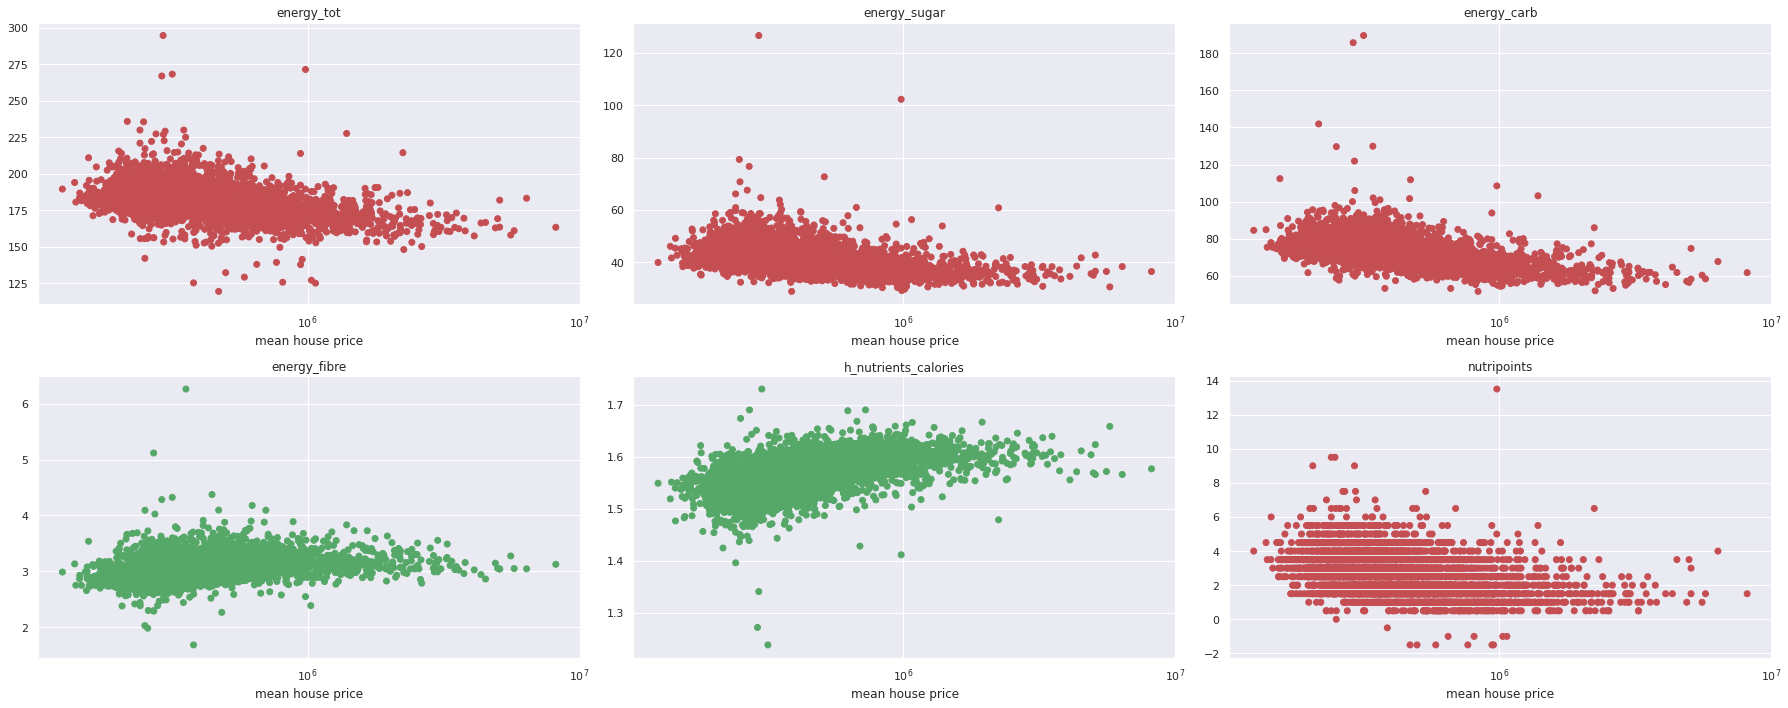

In [11]:
COLS_CORRELATED = ["energy_tot", "energy_sugar", "energy_carb",
                   "energy_fibre", "h_nutrients_calories", "nutripoints"]
colors = ["r", "r", "r", "g", "g", "r"]

N = len(COLS_CORRELATED)

fig, ax = plt.subplots(2, 3, figsize=(25, 10))

for i, col in enumerate(COLS_CORRELATED):
    ax[int(i / 3), i % 3].scatter(grocery_housing["mean house price"],
                                  y=grocery_housing[col], c=[colors[i]] * len(grocery_housing))
    ax[int(i / 3), i % 3].set(xscale="log",
                              title=col, xlabel="mean house price")

fig.tight_layout()

Nutripoints are negatively related to mean house prices. The graph on the ri

In [12]:
house_prices_median = grocery_housing["mean house price"].median()


def classify_median(row, median):
    if row["mean house price"] > median:
        return "high"
    else:
        return "low"


grocery_housing["pricing"] = grocery_housing.apply(
    lambda i: classify_median(i, house_prices_median), axis=1)

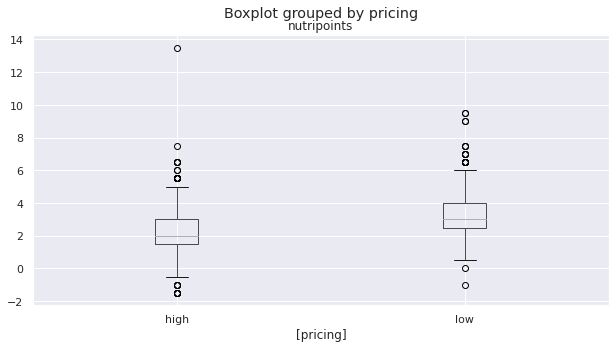

In [13]:
grocery_housing[['nutripoints', 'pricing']
                ].boxplot(by='pricing', figsize=(10, 5))

plt.show()

## III) Predictive Models

In [14]:
scaler = StandardScaler()
grocery_housing.dropna(axis=0, inplace=True)
grocery_housing_stand = grocery_housing.copy()
grocery_housing_stand[["mean house price", "nutripoints"]] = scaler.fit_transform(
    grocery_housing[["mean house price", "nutripoints"]])

X = grocery_housing_stand[["mean house price"]]
y = grocery_housing_stand["nutripoints"]

In [15]:
# Create the models

lin_reg = LinearRegression()
gb_boost_reg = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100)
ridge_reg = Ridge(alpha=.5)
mlp_reg = MLPRegressor(solver='lbfgs', alpha=1e-5,
                       hidden_layer_sizes=(5, 2))
dt_reg = DecisionTreeRegressor()

mse_scores = {}

reg_models = [lin_reg, gb_boost_reg, ridge_reg, mlp_reg, dt_reg]

mse = 'neg_mean_squared_error'

for model in reg_models:
    model_scores = cross_validate(model, X, y, cv=5, scoring=[mse])

    mse_scores[type(model).__name__] = model_scores["test_" + mse]

pp.pprint(mse_scores)

{'DecisionTreeRegressor': array([-1.66711984, -1.65989584, -1.51744748, -1.46620219, -1.49184741]),
 'GradientBoostingRegressor': array([-0.94926914, -0.66316289, -0.84293077, -0.7667037 , -0.88419407]),
 'LinearRegression': array([-1.04966353, -0.65332088, -0.98581116, -0.86349151, -1.02477554]),
 'MLPRegressor': array([-0.93981573, -0.63694778, -1.08425805, -0.76413984, -1.05021757]),
 'Ridge': array([-1.04967283, -0.65332535, -0.98578872, -0.86350062, -1.02474388])}


In [16]:
mse_scores_df = pd.DataFrame(mse_scores).abs()

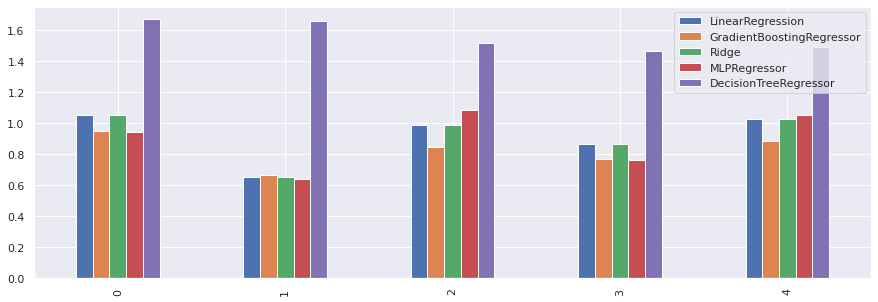

In [17]:
ax = mse_scores_df.plot.bar(figsize=(15, 5))

In [18]:
best_model = mse_scores_df.mean(axis=0).idxmin()

print(best_model)

GradientBoostingRegressor


## IV) Conclusion